Instructions on how to run \
Run in google colab with GPU acceleration with noisy-images.zip, test.csv, and train.csv in the content folder. The predictions will be outputted in output.csv, also in the content folder.

In [56]:
!unzip noisy-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: noisy-images/20236.jpg  
  inflating: noisy-images/49375.jpg  
  inflating: noisy-images/14050.jpg  
  inflating: noisy-images/40483.jpg  
  inflating: noisy-images/37230.jpg  
  inflating: noisy-images/57520.jpg  
  inflating: noisy-images/8022.jpg   
  inflating: noisy-images/9633.jpg   
  inflating: noisy-images/12046.jpg  
  inflating: noisy-images/34432.jpg  
  inflating: noisy-images/9543.jpg   
  inflating: noisy-images/26942.jpg  
  inflating: noisy-images/43224.jpg  
  inflating: noisy-images/55124.jpg  
  inflating: noisy-images/25079.jpg  
  inflating: noisy-images/28446.jpg  
  inflating: noisy-images/20772.jpg  
  inflating: noisy-images/26843.jpg  
  inflating: noisy-images/9673.jpg   
  inflating: noisy-images/19785.jpg  
  inflating: noisy-images/27456.jpg  
  inflating: noisy-images/8864.jpg   
  inflating: noisy-images/46909.jpg  
  inflating: noisy-images/17494.jpg  
  inflating: noisy-images/48774.jpg  

In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import string
import unicodedata
import re

In [58]:
class Lang:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.n_words = 0

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            if len(word) <= 2:
                continue
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2count:
            self.word2count[word] = 1
        else:
            self.word2count[word] += 1

    def trim(self, min_occurrences):
        self.word2count = {key: val for key, val in self.word2count.items() if val >= min_occurrences}
        self.n_words = len(self.word2count)
        for i, key in enumerate(self.word2count):
            self.word2index[key] = i
            self.index2word[i] = key

lang = Lang()

In [59]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [60]:
train_df = pd.read_csv('train.csv')
all_categories = train_df['category'].unique()
n_categories = len(all_categories)
category_to_idx = {category : i for i, category in enumerate(all_categories)}

all_genders = train_df['gender'].unique()
n_genders = len(all_genders)
gender_to_idx = {gender : i for i, gender in enumerate(all_genders)}

all_colours = train_df['baseColour'].unique()
n_colours = len(all_colours)
colour_to_idx = {colour : i for i, colour in enumerate(all_colours)}

all_seasons = train_df['season'].unique()
n_seasons = len(all_seasons)
season_to_idx = {season : i for i, season in enumerate(all_seasons)}

all_usages = train_df['usage'].unique()
n_usages = len(all_usages)
usage_to_idx = {usage : i for i, usage in enumerate(all_usages)}

def textToTensor(text, lang=lang):
    text = normalizeString(text).split()
    text = [word for word in text if len(word) > 2]
    tensor = torch.zeros(len(text), 1, lang.n_words)
    for li, word in enumerate(text):
        if word not in lang.word2index:
            continue
        tensor[li][0][lang.word2index[word]] = 1
    return tensor

test_df = pd.read_csv('test.csv')

img_path = 'noisy-images/'

In [61]:
for row in train_df['noisyTextDescription']:
    lang.addSentence(normalizeString(row))

for row in test_df['noisyTextDescription']:
    lang.addSentence(normalizeString(row))

lang.trim(212)

In [62]:
class CatDataset(torch.utils.data.Dataset):
    def __init__(self, df, is_train):
        self.df = df
        self.is_train = is_train
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, key):
        row = self.df.iloc[key]
        product_id = row['id']
        
        categorical_tensor = torch.zeros(1, n_genders + n_colours + n_seasons + n_usages)
        gender = gender_to_idx[row['gender']]
        categorical_tensor[0][gender] = 1
        colour = colour_to_idx[row['baseColour']]
        categorical_tensor[0][n_genders + colour] = 1
        season = season_to_idx[row['season']]
        categorical_tensor[0][n_genders + n_colours + season] = 1
        usage = usage_to_idx[row['usage']]
        categorical_tensor[0][n_genders + n_colours + n_seasons + usage] = 1
        
        if self.is_train:
            category = category_to_idx[row['category']]
        else:
            category = 0
        
        return product_id, categorical_tensor, category

In [63]:
class ImgDataset(torch.utils.data.Dataset):
    def __init__(self, df, is_train):
        self.df = df
        self.is_train = is_train
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, key):
        row = self.df.iloc[key]
        product_id = row['id']
        img = torchvision.transforms.functional.to_tensor(np.copy(plt.imread(img_path + str(product_id) + '.jpg')))
        if self.is_train:
            category = category_to_idx[row['category']]
        else:
            category = 0
        return product_id, img, category

In [64]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, df, is_train):
        self.df = df
        self.is_train = is_train
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, key):
        row = self.df.iloc[key]
        product_id = row['id']
                 
        text = textToTensor(row['noisyTextDescription'])
        
        if self.is_train:
            category = category_to_idx[row['category']]
        else:
            category = 0
        return product_id, text, category

def padder(batch):
    product_ids = torch.IntTensor([data[0] for data in batch])
    padded = nn.utils.rnn.pad_sequence([data[1] for data in batch]).permute(1, 2, 0, 3)
    categories = torch.LongTensor([data[2] for data in batch])
    return product_ids, padded, categories

In [65]:
def rowToTensor(row):
    categorical_tensor = torch.zeros(1, n_genders + n_colours + n_seasons + n_usages)
    gender = gender_to_idx[row['gender']]
    categorical_tensor[0][gender] = 1
    colour = colour_to_idx[row['baseColour']]
    categorical_tensor[0][n_genders + colour] = 1
    season = season_to_idx[row['season']]
    categorical_tensor[0][n_genders + n_colours + season] = 1
    usage = usage_to_idx[row['usage']]
    categorical_tensor[0][n_genders + n_colours + n_seasons + usage] = 1
    return categorical_tensor

class ProductDataset(torch.utils.data.Dataset):
    def __init__(self, df, has_labels=True):
        self.df = df
        self.has_labels = has_labels
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, key):
        row = self.df.iloc[key]
        product_id = row['id']
        
        categorical_tensor = rowToTensor(row)
        text = textToTensor(row['noisyTextDescription'])
        img = torchvision.transforms.functional.to_tensor(np.copy(plt.imread(img_path + str(product_id) + '.jpg')))

        if self.has_labels:
            category = category_to_idx[row['category']]
        else:
            category = 0

        return product_id, categorical_tensor, text, img, category

def padder_full(batch):
    product_ids = torch.IntTensor([data[0] for data in batch])
    categoricals = torch.stack([data[1] for data in batch])
    padded = nn.utils.rnn.pad_sequence([data[2] for data in batch]).permute(1, 2, 0, 3)
    imgs = torch.stack([data[3] for data in batch])
    categories = torch.LongTensor([data[4] for data in batch])
    return product_ids, categoricals, padded, imgs, categories

In [66]:
batch_size = 64
n_workers = 2
full_img_trainset = ImgDataset(train_df, True)

train_size = int(0.8 * len(full_img_trainset))
test_size = len(full_img_trainset) - train_size
img_trainset, img_testset = torch.utils.data.random_split(full_img_trainset, [train_size, test_size])

img_train_dataloader = torch.utils.data.DataLoader(img_trainset, batch_size=batch_size, shuffle=True, num_workers=n_workers)
img_test_dataloader = torch.utils.data.DataLoader(img_testset, batch_size=batch_size, shuffle=True, num_workers=n_workers)

In [67]:
full_cat_trainset = CatDataset(train_df, True)

cat_trainset, cat_testset = torch.utils.data.random_split(full_cat_trainset, [train_size, test_size])
cat_train_dataloader = torch.utils.data.DataLoader(cat_trainset, batch_size=batch_size, shuffle=True, num_workers=n_workers)
cat_test_dataloader = torch.utils.data.DataLoader(cat_testset, batch_size=batch_size, shuffle=True, num_workers=n_workers)

In [68]:
full_text_trainset = TextDataset(train_df, True)

text_trainset, text_testset = torch.utils.data.random_split(full_text_trainset, [train_size, test_size])

text_train_dataloader = torch.utils.data.DataLoader(text_trainset, batch_size=batch_size, shuffle=True, num_workers=n_workers, collate_fn=padder)
text_test_dataloader = torch.utils.data.DataLoader(text_testset, batch_size=batch_size, shuffle=True, num_workers=n_workers, collate_fn=padder)

In [69]:
trainset = ProductDataset(train_df, True)
trainset, testset = torch.utils.data.random_split(trainset, [train_size, test_size])
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=n_workers, collate_fn=padder_full)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=n_workers, collate_fn=padder_full)

In [70]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [71]:
class NN(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(n_genders + n_colours + n_seasons + n_usages, hidden_size)
        self.fc2 = nn.Linear(hidden_size, n_categories)
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), 1)
        return x

In [72]:
# Define model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding='same')
        self.conv2 = nn.Conv2d(16, 16, 3, padding='same')
        self.conv3 = nn.Conv2d(16, 32, 3, padding='same')
        self.conv4 = nn.Conv2d(32, 32, 3, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(9600,512)
        self.fc2 = nn.Linear(512, n_categories)
        self.dp1 = nn.Dropout(p=0.25)
        self.dp2 = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dp1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dp1(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dp2(x)
        x = F.log_softmax(self.fc2(x), 1)
        return x

In [73]:
num_layers = 2
class RNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_GRU, self).__init__()

        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=0.16)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        
        out = self.i2o(out[:, -1, :])
        
        out = self.softmax(out) 
        return out

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))


In [74]:
class Combiner(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(n_categories * 3, hidden_size)
        self.fc2 = nn.Linear(hidden_size, n_categories)
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), 1)
        return x

In [75]:
loss_fn = nn.NLLLoss()

In [76]:
def trainCNN(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for batch, (_, X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_train_loss = train_loss / num_batches
    accuracy = correct / size
    return accuracy, average_train_loss

def trainRNN(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for batch, (_, X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X = X.reshape(-1, X.shape[2], lang.n_words)

        # reset gradient
        model.zero_grad()

        output = model(X)
        

        loss = loss_fn(output, y)
        train_loss += loss.item()
        correct += (output.argmax(1) == y).type(torch.float).sum().item()

        # compute gradient by backpropagation
        loss.backward()

        # update parameters
        optimizer.step()

    average_train_loss = train_loss / num_batches
    accuracy = correct / size
    return accuracy, average_train_loss

In [77]:
def testCNN(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for _, X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    average_test_loss = test_loss / num_batches
    accuracy = correct / size
    return accuracy, average_test_loss

def testRNN(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for _, X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = X.reshape(-1, X.shape[2], lang.n_words)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    average_test_loss = test_loss / num_batches
    accuracy = correct / size
    return accuracy, average_test_loss

In [78]:
def experiment(model, optimizer, train_dataloader, test_dataloader, trainer, tester, epochs=10, loss_fn=loss_fn):

    all_train_accuracies = []
    all_test_accuracies = []
    for t in tqdm(range(epochs)):
    
        # train
        train_accuracy, average_train_loss = trainer(train_dataloader, model, loss_fn, optimizer)
        all_train_accuracies += [train_accuracy]
    
        # test
        test_accuracy, average_test_loss = tester(test_dataloader, model, loss_fn)
        all_test_accuracies += [test_accuracy]
    
        print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")
        #print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}")
    return all_train_accuracies, all_test_accuracies


NN experiment
NN(
  (fc1): Linear(in_features=62, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=27, bias=True)
)


 10%|█         | 1/10 [00:04<00:43,  4.83s/it]

Epoch 1:	 Train accuracy: 37.0%	 Avg train loss: 2.394057	 Test accuracy: 42.8%	 Avg test loss: 1.933410


 20%|██        | 2/10 [00:09<00:35,  4.48s/it]

Epoch 2:	 Train accuracy: 47.3%	 Avg train loss: 1.795067	 Test accuracy: 50.3%	 Avg test loss: 1.684828


 30%|███       | 3/10 [00:14<00:33,  4.81s/it]

Epoch 3:	 Train accuracy: 51.5%	 Avg train loss: 1.643818	 Test accuracy: 52.6%	 Avg test loss: 1.586557


 40%|████      | 4/10 [00:18<00:27,  4.65s/it]

Epoch 4:	 Train accuracy: 52.4%	 Avg train loss: 1.578367	 Test accuracy: 53.3%	 Avg test loss: 1.541741


 50%|█████     | 5/10 [00:22<00:22,  4.47s/it]

Epoch 5:	 Train accuracy: 52.7%	 Avg train loss: 1.543377	 Test accuracy: 53.9%	 Avg test loss: 1.522594


 60%|██████    | 6/10 [00:27<00:18,  4.69s/it]

Epoch 6:	 Train accuracy: 53.1%	 Avg train loss: 1.522515	 Test accuracy: 53.7%	 Avg test loss: 1.501317


 70%|███████   | 7/10 [00:32<00:13,  4.52s/it]

Epoch 7:	 Train accuracy: 53.3%	 Avg train loss: 1.505709	 Test accuracy: 53.6%	 Avg test loss: 1.487559


 80%|████████  | 8/10 [00:36<00:08,  4.41s/it]

Epoch 8:	 Train accuracy: 53.6%	 Avg train loss: 1.493426	 Test accuracy: 54.0%	 Avg test loss: 1.482335


 90%|█████████ | 9/10 [00:41<00:04,  4.63s/it]

Epoch 9:	 Train accuracy: 53.9%	 Avg train loss: 1.485317	 Test accuracy: 54.1%	 Avg test loss: 1.484970


100%|██████████| 10/10 [00:45<00:00,  4.56s/it]


Epoch 10:	 Train accuracy: 53.9%	 Avg train loss: 1.476773	 Test accuracy: 53.6%	 Avg test loss: 1.472881
CNN experiment
CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=27, bias=True)
  (dp1): Dropout(p=0.25, inplace=False)
  (dp2): Dropout(p=0.5, inplace=False)
)


 10%|█         | 1/10 [00:13<01:57, 13.01s/it]

Epoch 1:	 Train accuracy: 56.6%	 Avg train loss: 1.711352	 Test accuracy: 69.1%	 Avg test loss: 1.187134


 20%|██        | 2/10 [00:26<01:43, 13.00s/it]

Epoch 2:	 Train accuracy: 71.9%	 Avg train loss: 1.208515	 Test accuracy: 75.5%	 Avg test loss: 1.035788


 30%|███       | 3/10 [00:38<01:30, 12.92s/it]

Epoch 3:	 Train accuracy: 75.3%	 Avg train loss: 1.092384	 Test accuracy: 78.2%	 Avg test loss: 0.979157


 40%|████      | 4/10 [00:51<01:17, 12.91s/it]

Epoch 4:	 Train accuracy: 77.1%	 Avg train loss: 1.027224	 Test accuracy: 78.6%	 Avg test loss: 0.955229


 50%|█████     | 5/10 [01:04<01:04, 12.93s/it]

Epoch 5:	 Train accuracy: 78.3%	 Avg train loss: 0.971993	 Test accuracy: 79.8%	 Avg test loss: 0.954630


 60%|██████    | 6/10 [01:17<00:51, 12.84s/it]

Epoch 6:	 Train accuracy: 79.2%	 Avg train loss: 0.925061	 Test accuracy: 79.5%	 Avg test loss: 0.946336


 70%|███████   | 7/10 [01:30<00:38, 12.83s/it]

Epoch 7:	 Train accuracy: 79.6%	 Avg train loss: 0.896793	 Test accuracy: 80.0%	 Avg test loss: 0.929687


 80%|████████  | 8/10 [01:43<00:25, 12.92s/it]

Epoch 8:	 Train accuracy: 80.3%	 Avg train loss: 0.859586	 Test accuracy: 80.3%	 Avg test loss: 0.984707


 90%|█████████ | 9/10 [01:56<00:12, 12.94s/it]

Epoch 9:	 Train accuracy: 81.1%	 Avg train loss: 0.821911	 Test accuracy: 80.8%	 Avg test loss: 0.914198


100%|██████████| 10/10 [02:09<00:00, 12.94s/it]


Epoch 10:	 Train accuracy: 81.2%	 Avg train loss: 0.794315	 Test accuracy: 80.9%	 Avg test loss: 0.951918
RNN experiment
RNN_GRU(
  (gru): GRU(136, 64, num_layers=2, batch_first=True, dropout=0.16)
  (i2o): Linear(in_features=64, out_features=27, bias=True)
  (softmax): LogSoftmax(dim=1)
)


 10%|█         | 1/10 [00:05<00:53,  5.97s/it]

Epoch 1:	 Train accuracy: 41.0%	 Avg train loss: 2.204199	 Test accuracy: 53.5%	 Avg test loss: 1.789241


 20%|██        | 2/10 [00:11<00:43,  5.43s/it]

Epoch 2:	 Train accuracy: 58.3%	 Avg train loss: 1.628454	 Test accuracy: 61.7%	 Avg test loss: 1.515006


 30%|███       | 3/10 [00:16<00:39,  5.67s/it]

Epoch 3:	 Train accuracy: 65.4%	 Avg train loss: 1.437554	 Test accuracy: 68.1%	 Avg test loss: 1.382827


 40%|████      | 4/10 [00:21<00:32,  5.41s/it]

Epoch 4:	 Train accuracy: 69.7%	 Avg train loss: 1.309586	 Test accuracy: 69.5%	 Avg test loss: 1.312690


 50%|█████     | 5/10 [00:27<00:27,  5.49s/it]

Epoch 5:	 Train accuracy: 71.0%	 Avg train loss: 1.247806	 Test accuracy: 70.2%	 Avg test loss: 1.269185


 60%|██████    | 6/10 [00:32<00:21,  5.43s/it]

Epoch 6:	 Train accuracy: 71.2%	 Avg train loss: 1.214208	 Test accuracy: 70.5%	 Avg test loss: 1.247461


 70%|███████   | 7/10 [00:37<00:15,  5.25s/it]

Epoch 7:	 Train accuracy: 71.4%	 Avg train loss: 1.198112	 Test accuracy: 70.3%	 Avg test loss: 1.230890


 80%|████████  | 8/10 [00:43<00:10,  5.46s/it]

Epoch 8:	 Train accuracy: 71.8%	 Avg train loss: 1.177349	 Test accuracy: 70.8%	 Avg test loss: 1.214960


 90%|█████████ | 9/10 [00:48<00:05,  5.26s/it]

Epoch 9:	 Train accuracy: 72.0%	 Avg train loss: 1.160898	 Test accuracy: 70.9%	 Avg test loss: 1.224474


100%|██████████| 10/10 [00:54<00:00,  5.44s/it]

Epoch 10:	 Train accuracy: 72.1%	 Avg train loss: 1.147710	 Test accuracy: 70.7%	 Avg test loss: 1.206591


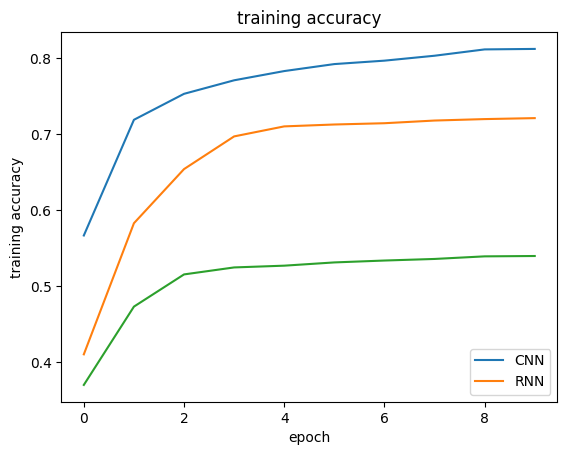

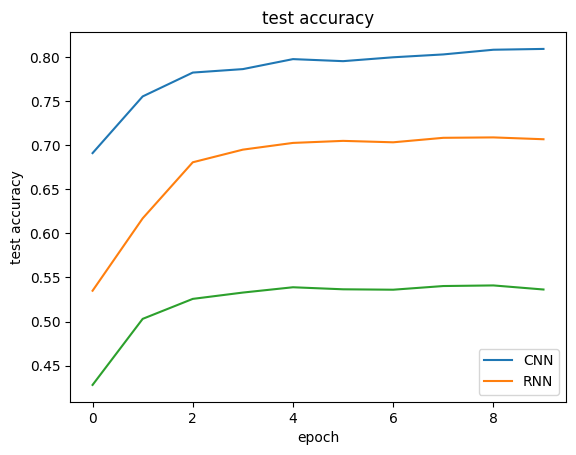

In [79]:
print('NN experiment')
basic_nn = NN(32).to(device)
print(basic_nn)
optimizer_nn = torch.optim.Adam(basic_nn.parameters())
all_train_accuracies_nn, all_test_accuracies_nn = experiment(basic_nn, optimizer_nn, cat_train_dataloader, cat_test_dataloader, trainCNN, testCNN)

print('CNN experiment')
cnn = CNN().to(device)
print(cnn)
optimizer_cnn = torch.optim.Adam(cnn.parameters())
all_train_accuracies_cnn, all_test_accuracies_cnn = experiment(cnn, optimizer_cnn, img_train_dataloader, img_test_dataloader, trainCNN, testCNN)

print('RNN experiment')
rnn = RNN_GRU(lang.n_words, 64, n_categories).to(device)
print(rnn)
optimizer_rnn = torch.optim.Adam(rnn.parameters())
all_train_accuracies_rnn, all_test_accuracies_rnn = experiment(rnn, optimizer_rnn, text_train_dataloader, text_test_dataloader, trainRNN, testRNN)
plt.plot(all_train_accuracies_cnn)
plt.plot(all_train_accuracies_rnn)
plt.plot(all_train_accuracies_nn)
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['CNN','RNN'], loc='lower right')
plt.show()

plt.plot(all_test_accuracies_cnn)
plt.plot(all_test_accuracies_rnn)
plt.plot(all_test_accuracies_nn)
plt.title('test accuracy')
plt.ylabel('test accuracy')
plt.xlabel('epoch')
plt.legend(['CNN','RNN'], loc='lower right')
plt.show()

accuracy_nn = all_test_accuracies_nn[-1]**2
accuracy_cnn = all_test_accuracies_cnn[-1]**2
accuracy_rnn = all_test_accuracies_rnn[-1]**2


27


 10%|█         | 1/10 [00:16<02:26, 16.33s/it]

Epoch 1:	 Train accuracy: 64.4%	 Avg train loss: 1.385543	 Test accuracy: 82.4%	 Avg test loss: 0.724229


 20%|██        | 2/10 [00:32<02:10, 16.30s/it]

Epoch 2:	 Train accuracy: 85.4%	 Avg train loss: 0.564888	 Test accuracy: 87.9%	 Avg test loss: 0.478947


 30%|███       | 3/10 [00:50<01:58, 16.88s/it]

Epoch 3:	 Train accuracy: 88.5%	 Avg train loss: 0.431598	 Test accuracy: 87.4%	 Avg test loss: 0.482720


 40%|████      | 4/10 [01:06<01:40, 16.74s/it]

Epoch 4:	 Train accuracy: 89.5%	 Avg train loss: 0.386403	 Test accuracy: 89.5%	 Avg test loss: 0.373791


 50%|█████     | 5/10 [01:23<01:24, 16.93s/it]

Epoch 5:	 Train accuracy: 90.0%	 Avg train loss: 0.359868	 Test accuracy: 89.6%	 Avg test loss: 0.358388


 60%|██████    | 6/10 [01:41<01:08, 17.16s/it]

Epoch 6:	 Train accuracy: 90.6%	 Avg train loss: 0.338931	 Test accuracy: 89.8%	 Avg test loss: 0.353251


 70%|███████   | 7/10 [01:58<00:50, 16.96s/it]

Epoch 7:	 Train accuracy: 90.9%	 Avg train loss: 0.327625	 Test accuracy: 90.4%	 Avg test loss: 0.334912


 80%|████████  | 8/10 [02:14<00:33, 16.88s/it]

Epoch 8:	 Train accuracy: 91.0%	 Avg train loss: 0.320621	 Test accuracy: 90.5%	 Avg test loss: 0.339601


 90%|█████████ | 9/10 [02:32<00:17, 17.09s/it]

Epoch 9:	 Train accuracy: 91.3%	 Avg train loss: 0.311785	 Test accuracy: 90.5%	 Avg test loss: 0.329260


100%|██████████| 10/10 [02:48<00:00, 16.87s/it]

Epoch 10:	 Train accuracy: 91.5%	 Avg train loss: 0.305093	 Test accuracy: 90.1%	 Avg test loss: 0.337652


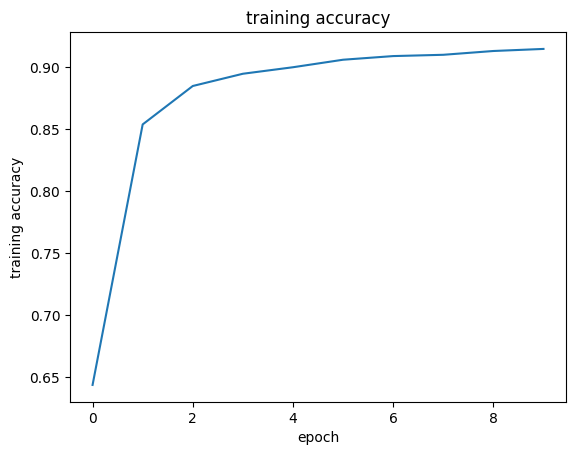

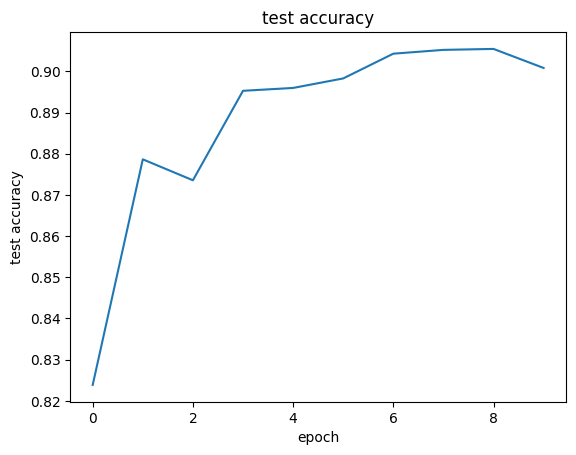

In [80]:
print(n_categories)
basic_nn.eval()
cnn.eval()
rnn.eval()

combiner = Combiner(n_categories * 2).to(device)
optimizer_combiner = torch.optim.Adam(combiner.parameters())

all_train_accuracies = []
all_test_accuracies = []
for t in tqdm(range(10)):

    # train
    size = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)
    combiner.train()
    train_loss, correct = 0, 0
    for batch, (_, cat, text, img, y) in enumerate(train_dataloader):
        cat, text, img, y = cat.to(device), text.to(device), img.to(device), y.to(device)
        text = text.reshape(-1, text.shape[2], lang.n_words)

        # Compute prediction error
        pred_nn = basic_nn(cat)
        pred_rnn = rnn(text)
        pred_cnn = cnn(img)
        joined_pred = torch.cat((pred_nn, pred_rnn, pred_cnn), 1).to(device).detach()

        pred_combined = combiner(joined_pred)

        loss = loss_fn(pred_combined, y)
        train_loss += loss.item()
        correct += (pred_combined.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer_combiner.zero_grad()
        loss.backward()
        optimizer_combiner.step()

    average_train_loss = train_loss / num_batches
    train_accuracy = correct / size
    all_train_accuracies += [train_accuracy]

    # test
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    combiner.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for _, cat, text, img, y in test_dataloader:
            cat, text, img, y = cat.to(device), text.to(device), img.to(device), y.to(device)
            text = text.reshape(-1, text.shape[2], lang.n_words)

            pred_nn = basic_nn(cat)
            pred_rnn = rnn(text)
            pred_cnn = cnn(img)
            joined_pred = torch.cat((pred_nn, pred_rnn, pred_cnn), 1).to(device).detach()

            pred_combined = combiner(joined_pred)

            test_loss += loss_fn(pred_combined, y).item()
            correct += (pred_combined.argmax(1) == y).type(torch.float).sum().item()

    average_test_loss = test_loss / num_batches
    test_accuracy = correct / size
    all_test_accuracies += [test_accuracy]

    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")
    #print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}")

plt.plot(all_train_accuracies)
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.show()

plt.plot(all_test_accuracies)
plt.title('test accuracy')
plt.ylabel('test accuracy')
plt.xlabel('epoch')
plt.show()

27


100%|██████████| 10/10 [02:58<00:00, 17.90s/it]


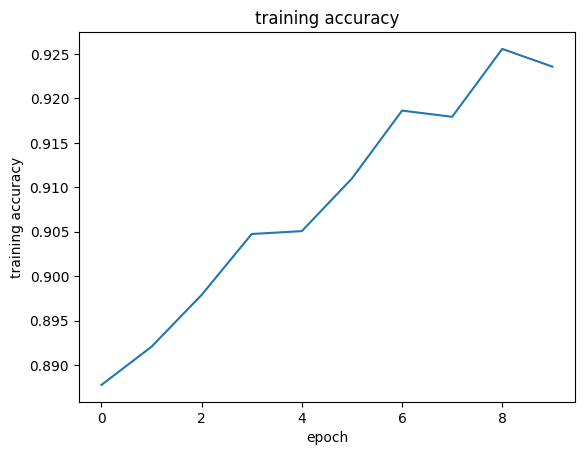

In [81]:
print(n_categories)

trainset = ProductDataset(train_df, True)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=n_workers, collate_fn=padder_full)

basic_nn.train()
rnn.train()
cnn.train()
combiner.train()

all_train_accuracies = []
for t in tqdm(range(10)):

    # train
    size = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)

    train_loss, correct = 0, 0
    for batch, (_, cat, text, img, y) in enumerate(train_dataloader):
        cat, text, img, y = cat.to(device), text.to(device), img.to(device), y.to(device)
        text = text.reshape(-1, text.shape[2], lang.n_words)

        # Compute prediction error
        pred_nn = basic_nn(cat)
        pred_rnn = rnn(text)
        pred_cnn = cnn(img)
        joined_pred = torch.cat((pred_nn, pred_rnn, pred_cnn), 1).to(device).detach()

        pred_combined = combiner(joined_pred)

        loss_cat = loss_fn(pred_nn, y)
        loss_rnn = loss_fn(pred_rnn, y)
        loss_cnn = loss_fn(pred_cnn, y)
        loss_combined = loss_fn(pred_combined, y)
        train_loss += loss_combined.item()
        correct += (pred_combined.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer_nn.zero_grad()
        optimizer_rnn.zero_grad()
        optimizer_cnn.zero_grad()
        optimizer_combiner.zero_grad()
        loss_cat.backward()
        loss_rnn.backward()
        loss_cnn.backward()
        loss_combined.backward()
        optimizer_nn.step()
        optimizer_rnn.step()
        optimizer_cnn.step()
        optimizer_combiner.step()

    average_train_loss = train_loss / num_batches
    train_accuracy = correct / size
    all_train_accuracies += [train_accuracy]

plt.plot(all_train_accuracies)
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.show()

In [82]:
full_testset = ProductDataset(test_df, False)

full_dataloader = torch.utils.data.DataLoader(full_testset, batch_size=1, shuffle=False, num_workers=0, collate_fn = padder_full)
cnn.eval()
rnn.eval()
basic_nn.eval()
combiner.eval()


with torch.no_grad():
    with open('output.csv', 'w') as file:
        file.write('id,category\n')
        for product_id, cat, text, img, _ in full_dataloader:
            pid = product_id.item()
            text = text.to(device)
            text = text.reshape(-1, text.shape[2], lang.n_words)
            img = img.to(device)
            cat = cat.to(device)
            cat_pred = basic_nn(cat)
            img_pred = cnn(img)
            text_pred = rnn(text)
            joined_pred = torch.cat((cat_pred, text_pred, img_pred), 1).to(device)
            pred_combined = combiner(joined_pred)
            weighted_pred = pred_combined.argmax(1).item()
            file.write(f'{pid},{all_categories[weighted_pred]}\n')
                